In [1]:
pip install pandas numpy coolprop matplotlib scipy

   ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.4 MB ? eta -:--:--
   --------------- ------------------------ 2.1/5.4 MB 7.8 MB/s eta 0:00:01
   --------------------------------- ------ 4.5/5.4 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 5.4/5.4 MB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


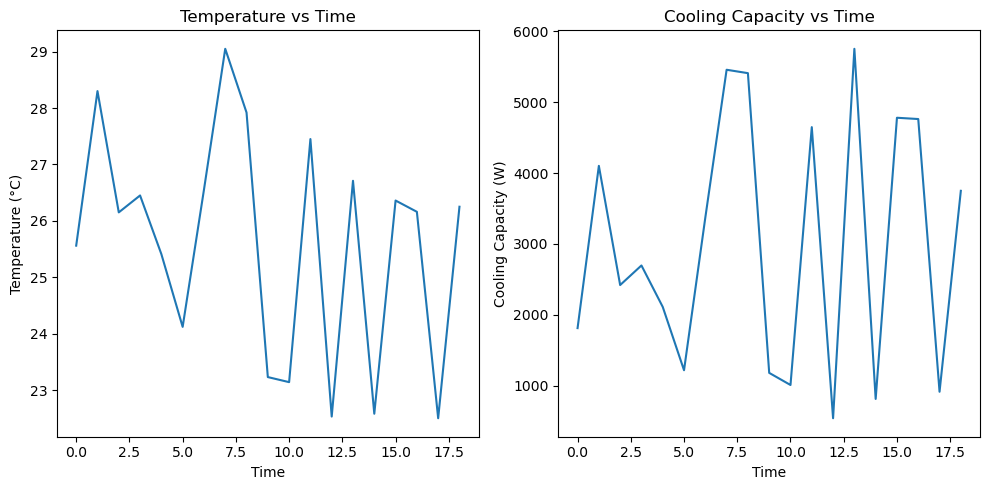

In [5]:
import pandas as pd
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

# 空调系统热力学模型（基于CoolProp）
class ACSystemThermodynamics:
    def __init__(self, refrigerant="R134a"):
        self.refrigerant = refrigerant

    def get_enthalpy(self, T, P):
        """
        获取特定温度和压力下冷媒的焓值（单位：J/kg）
        """
        h = CP.PropsSI('H', 'T', T + 273.15, 'P', P * 1e3, self.refrigerant)  # 温度单位°C，压力单位bar
        return h

    def get_specific_heat(self, T, P):
        """
        获取特定温度和压力下冷媒的比热容（单位：J/kg·K）
        """
        cp = CP.PropsSI('C', 'T', T + 273.15, 'P', P * 1e3, self.refrigerant)
        return cp

    def calculate_work(self, mass_flow_rate, T_in, P_in, T_out, P_out):
        """
        计算压缩机的功率需求
        这里假设为简单的等熵压缩
        """
        h_in = self.get_enthalpy(T_in, P_in)
        h_out = self.get_enthalpy(T_out, P_out)
        work = mass_flow_rate * (h_out - h_in)  # 单位：W (瓦)
        return work

# 空调系统能效计算
class ACEfficiency:
    def __init__(self, COP_base=4.0):
        """
        初始化空调的COP（性能系数）
        COP是空调效率的关键参数，表示输出冷量与输入功率的比率
        """
        self.COP_base = COP_base  # 空调基础COP值（可以根据环境条件调整）

    def calculate_cooling_capacity(self, work_input):
        """
        根据压缩机的输入功率计算空调的冷却能力（单位：W）
        """
        cooling_capacity = work_input * self.COP_base
        return cooling_capacity

# 控制算法（PID控制）
class ACControl:
    def __init__(self, set_point=24.0, Kp=1.0, Ki=0.1, Kd=0.05):
        """
        初始化PID控制器
        set_point为设定温度
        """
        self.set_point = set_point  # 目标温度
        self.pid = PID(Kp, Ki, Kd)
    
    def adjust_system(self, current_temp):
        """
        根据当前温度调整空调的工作状态
        """
        control_signal = self.pid.compute(self.set_point, current_temp)
        return control_signal

class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def compute(self, set_point, current_value):
        error = set_point - current_value
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

# 数据读取和预处理
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data.fillna(data.mean(), inplace=True)  # 填充缺失值
    return data

# 模拟空调系统的工作状态
def simulate_ac_system(file_path):
    # 加载数据
    data = load_data(file_path)
    data = preprocess_data(data)

    # 创建空调系统实例
    thermodynamics = ACSystemThermodynamics(refrigerant="R134a")
    efficiency = ACEfficiency(COP_base=4.0)
    control = ACControl(set_point=24.0)

    # 模拟温度变化
    temperatures = []
    cooling_capacities = []
    work_inputs = []

    for index, row in data.iterrows():
        current_temp = row['temperature']
        humidity = row['humidity']
        flow = row['flow']

        # 使用控制算法调整空调系统
        control_signal = control.adjust_system(current_temp)

        # 模拟空调系统的工作
        mass_flow_rate = flow * 0.001  # 假设流量转换成质量流量（单位：kg/s）

        # 假设系统进出口温度变化
        T_in = current_temp
        T_out = current_temp - control_signal
        P_in = 2.0  # 进气压力假设为2 bar
        P_out = 7.0  # 出气压力假设为7 bar

        # 计算空调压缩机功率需求
        work_input = thermodynamics.calculate_work(mass_flow_rate, T_in, P_in, T_out, P_out)

        # 计算冷却能力
        cooling_capacity = efficiency.calculate_cooling_capacity(work_input)

        # 存储模拟结果
        temperatures.append(current_temp)
        cooling_capacities.append(cooling_capacity)
        work_inputs.append(work_input)

    # 可视化结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(temperatures, label="Temperature (°C)")
    plt.title("Temperature vs Time")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    
    plt.subplot(1, 2, 2)
    plt.plot(cooling_capacities, label="Cooling Capacity (W)")
    plt.title("Cooling Capacity vs Time")
    plt.xlabel("Time")
    plt.ylabel("Cooling Capacity (W)")
    plt.tight_layout()
    plt.show()

# 主函数
if __name__ == "__main__":
    file_path = "work1.csv"  # 替换为你的数据文件路径
    simulate_ac_system(file_path)